In [1]:
#Nescessary imports
from PIL import Image
import torch
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import numpy as np
from fastai.vision.all import *


# instantiating models (with default and random weights)
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)

C:\Users\erikm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# imports to get imgs
import os
from pathlib import Path
cwd = os.getcwd()
cwd

'c:\\Users\\erikm\\Desktop\\Thesis'

In [3]:
imgs_path = Path(cwd + '\\imgs')

In [4]:
from torchvision import transforms as T

def resize_img(img_path):
	#open
	img = Image.open(img_path).convert('RGB')
	# define transform
	transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
	#do transformation
	resized_image = transform(img).unsqueeze(dim=0)
	return resized_image

images = 4
shape = torch.Size([1, 3, 224, 224])


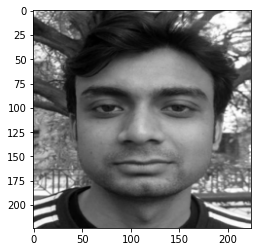

In [5]:
# list file_names in dir
list_of_file_names = os.listdir(imgs_path)
# change directory to current path
os.chdir(imgs_path)
#create list for imgs (these images are from the article: https://www.nature.com/articles/s41467-021-22078-3 )
# This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s).
imgs = []
for file_name in list_of_file_names:
	img = resize_img(file_name)
	imgs.append(img)
# expecting 4 images, as 1, 3, 224, 224 tensor
print (f'images = {len(imgs)}')
print (f'shape = {imgs[0].shape}')

#show img
import matplotlib.pyplot as plt
plt.imshow(np.transpose(imgs[0].numpy()[0], (1,2,0)))

In [6]:
# define hook: 
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [7]:
# def register hook to feature layers, and all but the final classifaction layer
def register_hooks(model):
	hooks = []
	for i in range(len(model.features)):
		h = model.features[i].register_forward_hook(getActivation(f'features{i}'))
		hooks.append(h)
	for i in range(len(model.classifier)-1):
		h = model.classifier[i].register_forward_hook(getActivation(f'classifier{i}'))
		hooks.append(h)
	return hooks

In [8]:
hooks = register_hooks(vgg_model)
len(hooks)

37

In [9]:
# define get_activations function
def get_activations_w_hook(img):
	vgg_model(img)
	return activation

In [10]:
activations = []
for img in imgs:
	act = get_activations_w_hook(img)
	# extract values from dict
	values_list = [act[key] for key in act]
	activations.append(values_list)
print (f'number of images checked: {len(activations)}')
print (f'number of layers: {len(activations[0])}')

number of images checked: 4
number of layers: 37


In [31]:
#define calc_dist function
def calc_distances(activation_list, idx0, idx1):
	distances = []
	for layer in range(len(activation_list[0])):
		# flatten vectors
		vector1 = activation_list[idx0][layer].flatten(1)
		vector2 = activation_list[idx1][layer].flatten(1)
		# Compare with distance metric
		distance = torch.cdist(vector1, vector2)
		distances.append(distance)
	return distances

In [34]:
dist_1 = calc_distances(activations, 0, 1)
dist_2 = calc_distances(activations, 2, 3)

In [45]:
#calc_distance between distance vectors:
final_dists = []
for i in range(len(dist_1)):
	final_dist = torch.cdist(dist_1[i], dist_2[i])
	final_dists.append(final_dist)

C:\Users\erikm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\erikm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

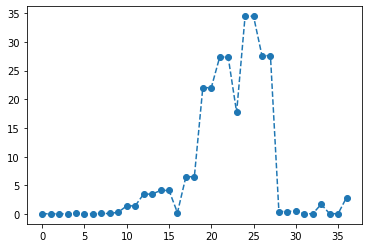

In [38]:
# plot distances
plt.plot(final_dists, marker='o', linestyle='--')

In [41]:
# show features to see which layers are relus/conv2d:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [42]:
# Check if values are identical
final_dists[0], final_dists[1]

(tensor([[0.0563]]), tensor([[0.0563]]))

In [44]:
# Check again if values are identical
final_dists[17], final_dists[18]

(tensor([[6.5119]]), tensor([[6.5119]]))